In [43]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

tickers = ["AAPL", "TSLA"]
stocks = {}

for ticker in tickers:
    stocks[ticker] = pd.read_csv("./archive/stocks/{}.csv".format(ticker))

In [44]:
stocks['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...,...
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500


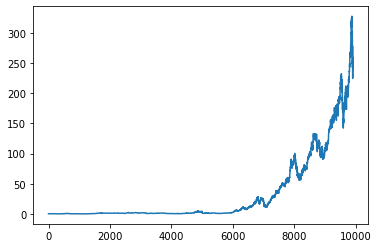

In [45]:
plt.plot(stocks['AAPL']['Close'])

In [46]:
def moving_average(ts, window):
    result = np.array([])
    for i in range(len(ts) - window):
        result = np.append(result, np.mean(ts[i:i+window]))
    return result

In [47]:
def median_filter(ts, window):
    result = np.array([])
    for i in range(len(ts) - window):
        result = np.append(result, np.median(ts[i:i+window]))
    return result

In [48]:
def average_ds(ts, window):
    result = np.array([])
    for i in range(int(len(ts)/window)):
        result = np.append(result, np.mean(ts[i*window : (i+1)*window]))
    return result

In [49]:
def median_ds(ts, window):
    result = np.array([])
    for i in range(int(len(ts)/window)):
        result = np.append(result, np.median(ts[i*window : (i+1)*window]))
    return result

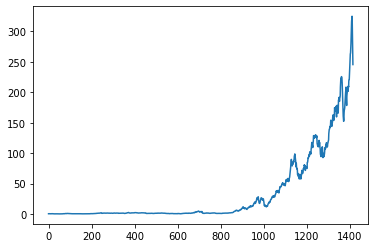

In [50]:
plt.plot(median_ds(stocks['AAPL']['Close'], 7))

In [86]:
ts = stocks['AAPL']['Close']
ts = np.array(ts).reshape(-1,1)

In [87]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ts)

In [88]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [89]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
        
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [90]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
7925/7925 - 8s - loss: 3.2865e-04
Epoch 2/30
7925/7925 - 6s - loss: 2.1182e-06
Epoch 3/30
7925/7925 - 7s - loss: 2.1298e-06
Epoch 4/30
7925/7925 - 5s - loss: 1.9518e-06
Epoch 5/30
7925/7925 - 6s - loss: 2.0936e-06
Epoch 6/30
7925/7925 - 5s - loss: 2.0380e-06
Epoch 7/30
7925/7925 - 5s - loss: 1.9475e-06
Epoch 8/30
7925/7925 - 5s - loss: 1.9667e-06
Epoch 9/30
7925/7925 - 5s - loss: 1.9179e-06
Epoch 10/30
7925/7925 - 5s - loss: 1.9716e-06
Epoch 11/30
7925/7925 - 5s - loss: 2.0027e-06
Epoch 12/30
7925/7925 - 5s - loss: 1.9365e-06
Epoch 13/30
7925/7925 - 6s - loss: 1.8645e-06
Epoch 14/30
7925/7925 - 5s - loss: 1.9851e-06
Epoch 15/30
7925/7925 - 7s - loss: 1.9696e-06
Epoch 16/30
7925/7925 - 6s - loss: 1.9634e-06
Epoch 17/30
7925/7925 - 6s - loss: 1.8806e-06
Epoch 18/30
7925/7925 - 6s - loss: 1.8556e-06
Epoch 19/30
7925/7925 - 7s - loss: 1.9003e-06
Epoch 20/30
7925/7925 - 9s - loss: 1.7839e-06
Epoch 21/30
7925/7925 - 6s - loss: 1.9715e-06
Epoch 22/30
7925/7925 - 6s - loss: 1.7941e-

Train Score: 0.35 RMSE
Test Score: 19.97 RMSE


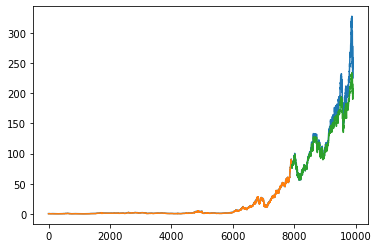

In [92]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()